# Shape from Shading experiments

According to all these trials, single light source should be diffused to avoid the hard shadow. The albedo image should light up whole region without any shadow, and this will be used as a base to separate the geometry from slope images.
One more thing noticed or realized, as gradient operation is a type of high pass filter, therefore, large region reflection is filtered out as low frequency.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

from skimage.transform.integral import integral_image

In [ ]:
!ls

In [ ]:
def show_img(imgs):
    f = plt.figure()
    for i in range(len(imgs)):
        f.add_subplot(1,len(imgs), i+1)
        plt.imshow(imgs[i], cmap='gray')
    plt.show(block=True)

In [ ]:
# top = cv2.imread("top.JPG", cv2.IMREAD_GRAYSCALE)
# right = cv2.imread("right.JPG", cv2.IMREAD_GRAYSCALE)
left = cv2.imread("left.JPG", cv2.IMREAD_GRAYSCALE)
down = cv2.imread("down.JPG", cv2.IMREAD_GRAYSCALE)
albedo = cv2.imread("albedo.JPG", cv2.IMREAD_GRAYSCALE)

In [ ]:
show_img([left, down, albedo])

In [ ]:
left = left[1500:2500, 1000:2000]
down = down[1500:2500, 1000:2000]
albedo = albedo[1500:2500, 1000:2000]

In [ ]:
show_img([left, down, albedo])

In [ ]:
avg_left = np.mean(left[0:200])
avg_down = np.mean(down[0:200])
avg_albedo = np.mean(albedo[0:200])
print(avg_left, avg_down, avg_albedo)

scale_x = avg_left/avg_albedo
scale_y = avg_down/avg_albedo
print(scale_x, scale_y)

In [ ]:
def normalize(img, scale):
    return (img.astype(np.float32)/scale).astype(np.int16)

In [ ]:
left_norm = normalize(left, scale_x)
down_norm = normalize(down, scale_y)

avg_x = np.mean(left_norm[0:200])
avg_y = np.mean(down_norm[0:200])
print(avg_x, avg_y, avg_albedo)

In [ ]:
show_img([left_norm, down_norm, albedo])

## Op1: Subtract the albedo image from slop images

In [ ]:
left_sub = left_norm-1.2*albedo
down_sub = down_norm-1.2*albedo

show_img([left_sub, down_sub])

## Op2: Subtract the xy gradient image

In [ ]:
sobelx = cv2.Sobel(left_sub,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(down_sub,cv2.CV_64F,0,1,ksize=3)

sobelxa = cv2.Sobel(albedo,cv2.CV_64F,1,0,ksize=3)
sobelya = cv2.Sobel(albedo,cv2.CV_64F,0,1,ksize=3)

show_img([sobelx, sobely, sobelxa, sobelya])

In [ ]:
sobelx_org = cv2.Sobel(left,cv2.CV_64F,1,0,ksize=3)
sobely_org = cv2.Sobel(down,cv2.CV_64F,0,1,ksize=3)
show_img([sobelx-sobelxa, sobely-sobelya, sobelx_org-sobelxa, sobely_org-sobelya])

In [ ]:
show_img([sobelx+sobely, sobelx_org-sobelxa+sobely_org-sobelya])

## Now try the image online

In [62]:
baumer = cv2.imread("baumer.png", cv2.IMREAD_GRAYSCALE)

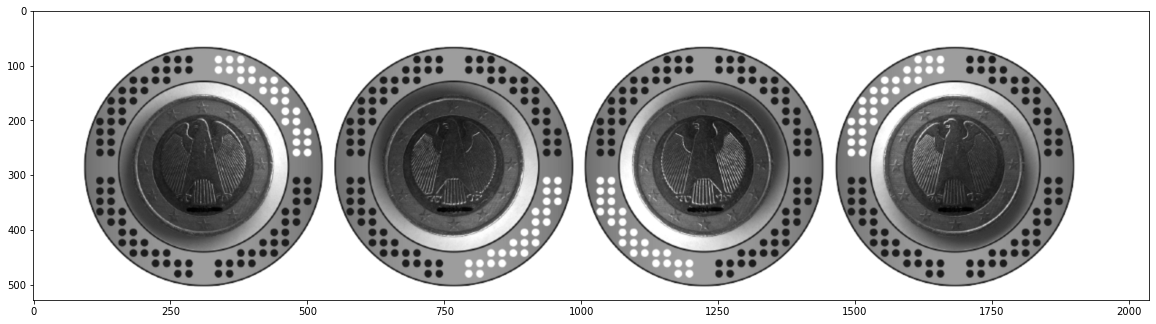

In [63]:
show_img([baumer])

### Get all the individual images

In [64]:
gray = cv2.medianBlur(baumer, 5)
rows = gray.shape[0]
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                           param1=100, param2=30,
                           minRadius=210, maxRadius=230)

In [65]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    print(circles)
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(baumer, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(baumer, center, radius, (255, 0, 255), 3)

[[[ 768  284  215]
  [1222  284  217]
  [1684  282  217]
  [ 310  286  216]]]


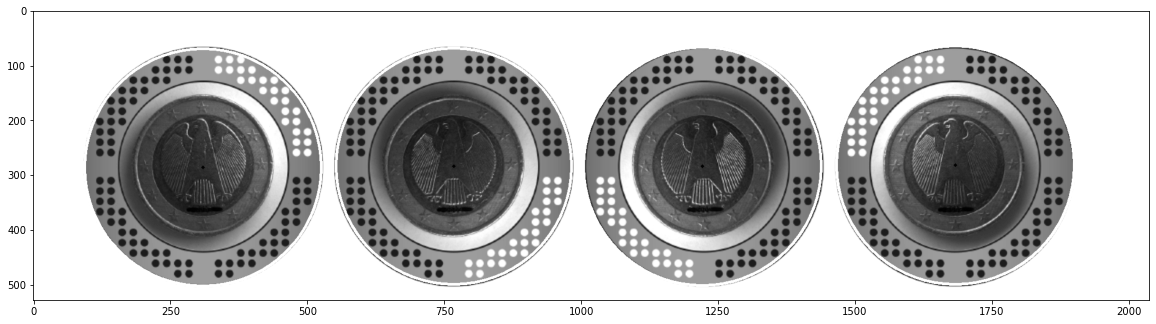

In [66]:
show_img([baumer])

In [67]:
circles_adjusted = [
    [310, 284, 216],
    [768, 284, 216],    
    [1222, 284, 216],
    [1684, 284, 216]
]

In [68]:
coins = baumer[:]
for circle in circles_adjusted:
    center = (circle[0], circle[1])
    cv2.circle(coins, center, 1, (0, 100, 100), 3)
    radius = circle[2]
    cv2.circle(coins, center, radius, (0, 0, 255), 3) 

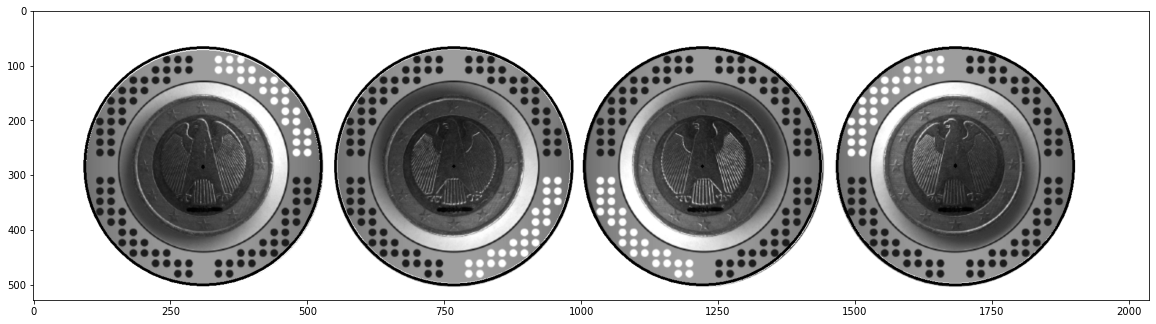

In [69]:
show_img([coins])

In [87]:
coins_sep = np.zeros((4, 216, 216))
for circle in circles_adjusted:
    i = 0
    x, y = circle[0], circle[1]
    print(x, y)
    coins_sep[i] = baumer[x-216//2:x+216//2, y-216//2:y+216//2]
    print(coins_sep)
    i += 1
print(coins_sep.shape)

310 284
[[[134. 126.  85. ... 104. 106. 106.]
  [125. 103.  59. ... 108. 106. 108.]
  [108.  67.  43. ... 108. 103. 105.]
  ...
  [140. 140. 139. ... 173. 171. 152.]
  [139. 140. 140. ... 157. 119.  89.]
  [137. 135. 123. ... 116.  74.  51.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]]
768 284


ValueError: could not broadcast input array from shape (0,216) into shape (216,216)